# cf-python Regridding

* **Metadata-aware regridding based on the ESMPy interface to the Earth System Modeling Framework (ESMF) library**
* **Coordinate systems: Spherical (regrids) or Cartesian (regridc)**
* **Regridding methods:**
    * **First order conservative** - conserves integral of field with respect to area
    * **Bilinear** - linear interpolation in 1-3 dimensions (2D for spherical coordinates)
    * **Higher order patch recovery** - polynomial based so better values/derivatives
    * **Nearest source to destination** - useful for integer fields such as land use
    * **Nearest destination to source** - multiple source points can contribute to one destination point
* **Global or regional source/destination grids in any combination**
* **Handles grids with 2D latitudes and longitudes including curvilinear, rotated pole and some tripolar grids**
* **Handles masking of both source and destination grids**

## Spherical regridding (`regrids`)

### Conservative regridding

In [1]:
# Inline images in IPython Notebook - not needed in Python
%matplotlib inline

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the cf and cfplot packages
import cf
import cfplot as cfp

In [3]:
# Read in ncas_data/precip_2010.nc and inspect the field
f = cf.read('ncas_data/precip_2010.nc')[0]
print(f)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(12), latitude(145), longitude(53)) mm
Dimension coords: long_name=time(12) = [2010-01-16 00:00:00, ..., 2010-12-16 00:00:00] gregorian
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(53) = [-33.75, ..., 63.75] degrees_east



In [4]:
# Read in ncas_data/model_precip_DJF_means_low_res.nc and inspect the field
g = cf.read('ncas_data/model_precip_DJF_means_low_res.nc')[0]
print(g)

Field: long_name=precipitation (ncvar%precip)
---------------------------------------------
Data            : long_name=precipitation(long_name=t(1), long_name=Surface(1), latitude(73), longitude(27)) mm/day
Cell methods    : long_name=t(1): mean
Dimension coords: long_name=t(1) = [1996-07-16 00:00:00] 360_day
                : long_name=Surface(1) = [0.0] level
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east



In [5]:
# Regrid the first field to the grid of the second and inspect the results
h = f.regrids(g, method='conservative')
print(h)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(12), latitude(73), longitude(27)) mm
Dimension coords: long_name=time(12) = [2010-01-16 00:00:00, ..., 2010-12-16 00:00:00] gregorian
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east



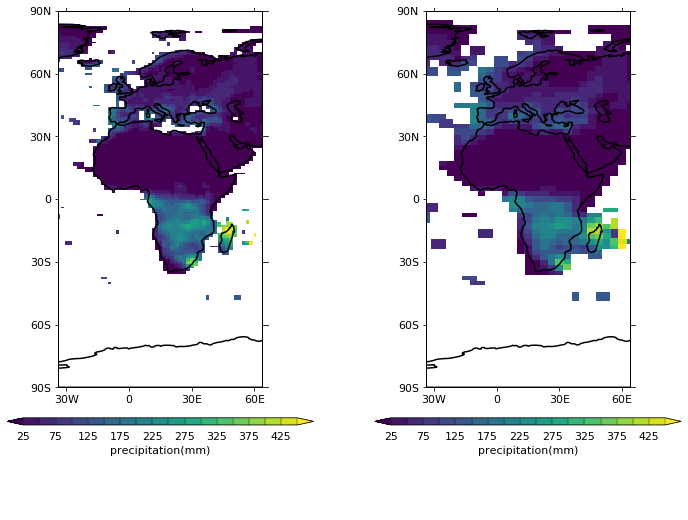

In [6]:
# Plot before and after
cfp.gopen(rows=1, columns=2)
cfp.gpos(1)
cfp.con(f[0], blockfill=True, lines=False, colorbar_label_skip=2)
cfp.gpos(2)
cfp.con(h[0], blockfill=True, lines=False, colorbar_label_skip=2)
cfp.gclose()

### Regridding from a tripolar grid

![alt text](https://www.gfdl.noaa.gov/wp-content/uploads/pix/user_images/mw/bipolar.gif "Tripolar Grid")

In [7]:
# Read in ncas_data/tripolar.nc and select and inspect a field
f = cf.read('ncas_data/tripolar.nc')[0]
print(f)

Field: sea_surface_height_above_geoid (ncvar%sossheig)
------------------------------------------------------
Data            : sea_surface_height_above_geoid(time(1), ncdim%y(332), ncdim%x(362)) m
Cell methods    : time(1): mean (interval: 2700 s)
Dimension coords: time(1) = [1978-09-06 00:00:00] 360_day
Auxiliary coords: time(time(1)) = [1978-09-06 00:00:00] 360_day
                : longitude(ncdim%y(332), ncdim%x(362)) = [[72.5, ..., 72.98915100097656]] degrees_east
                : latitude(ncdim%y(332), ncdim%x(362)) = [[-84.21070861816406, ..., 50.01094055175781]] degrees_north



In [8]:
# Read in ncas_data/model_precip_DJF_means.nc and inspect the field
g = cf.read('ncas_data/model_precip_DJF_means.nc')[0]
print(g)

Field: long_name=precipitation (ncvar%precip)
---------------------------------------------
Data            : long_name=precipitation(latitude(145), longitude(192)) mm/day
Cell methods    : long_name=t(1): mean
Dimension coords: latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(192) = [0.0, ..., 358.125] degrees_east
                : long_name=t(1) = [1996-07-16 00:00:00] 360_day
                : long_name=Surface(1) = [0.0] level



In [9]:
# Regrid the field on the tripolar grid to the regular lat-long grid
h = f.regrids(g, method='bilinear', src_axes={'X': 'ncdim%x', 'Y': 'ncdim%y'}, src_cyclic=True)
print(h)

Field: sea_surface_height_above_geoid (ncvar%sossheig)
------------------------------------------------------
Data            : sea_surface_height_above_geoid(time(1), latitude(145), longitude(192)) m
Cell methods    : time(1): mean (interval: 2700 s)
Dimension coords: time(1) = [1978-09-06 00:00:00] 360_day
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(192) = [0.0, ..., 358.125] degrees_east
Auxiliary coords: time(time(1)) = [1978-09-06 00:00:00] 360_day



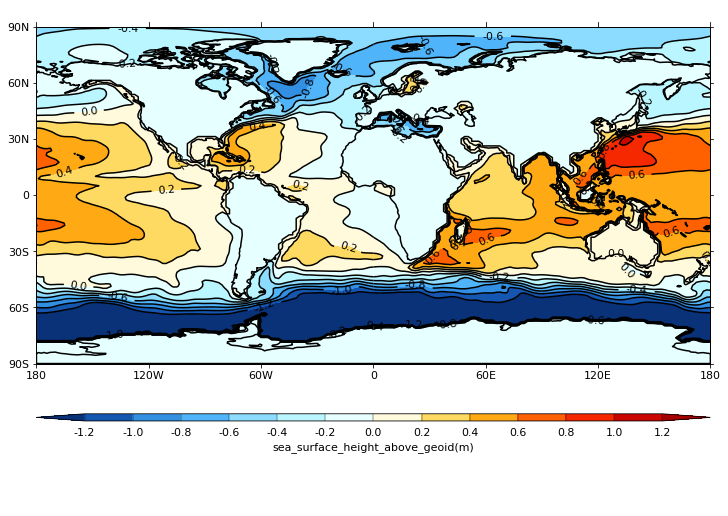

In [10]:
# Plot the regridded data
cfp.levs(min=-1.2, max=1.2, step=0.2)
cfp.con(h)

### Higher order patch recovery versus bilinear regridding

In [11]:
# Read in ncas_data/data5.nc and inspect the field
f = cf.read('ncas_data/data5.nc')[0].subspace[0, 0]
print(f)

Field: eastward_wind (ncvar%U)
------------------------------
Data            : eastward_wind(time(1), pressure(1), latitude(160), longitude(320)) m s**-1
Dimension coords: time(1) = [1987-03-15 00:00:00]
                : pressure(1) = [1000.0] mbar
                : latitude(160) = [89.14151763916016, ..., -89.14151763916016] degrees_north
                : longitude(320) = [0.0, ..., 358.875] degrees_east



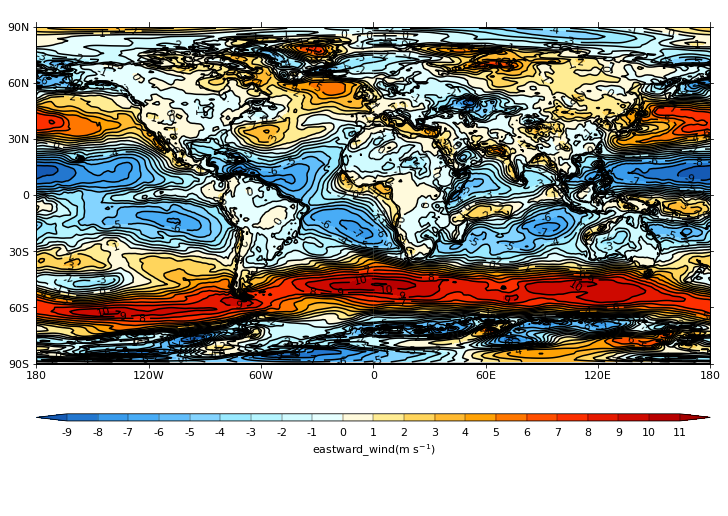

In [12]:
cfp.levs()
cfp.cscale()
cfp.con(f)

In [13]:
# Read in ncas_data/model_precip_DJF_means_low_res.nc and inspect the field
g = cf.read('ncas_data/model_precip_DJF_means_low_res.nc')[0]
print(g)

Field: long_name=precipitation (ncvar%precip)
---------------------------------------------
Data            : long_name=precipitation(long_name=t(1), long_name=Surface(1), latitude(73), longitude(27)) mm/day
Cell methods    : long_name=t(1): mean
Dimension coords: long_name=t(1) = [1996-07-16 00:00:00] 360_day
                : long_name=Surface(1) = [0.0] level
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east



In [14]:
# Regrid the first field to the grid of the second using bilinear interpolation
h = f.regrids(g, method='bilinear')
print(h)

Field: eastward_wind (ncvar%U)
------------------------------
Data            : eastward_wind(time(1), pressure(1), latitude(73), longitude(27)) m s**-1
Dimension coords: time(1) = [1987-03-15 00:00:00]
                : pressure(1) = [1000.0] mbar
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east



In [15]:
# Regrid the first field to the grid of the second using higher order patch recovery
i = f.regrids(g, method='patch')
print(i)

Field: eastward_wind (ncvar%U)
------------------------------
Data            : eastward_wind(time(1), pressure(1), latitude(73), longitude(27)) m s**-1
Dimension coords: time(1) = [1987-03-15 00:00:00]
                : pressure(1) = [1000.0] mbar
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east



In [16]:
# Find the y derivatives of the regridded fields
deriv_h = h.derivative('Y')
deriv_h.units = 'm.s-1.degrees-1'
deriv_i = i.derivative('Y')
deriv_i.units = 'm.s-1.degrees-1'

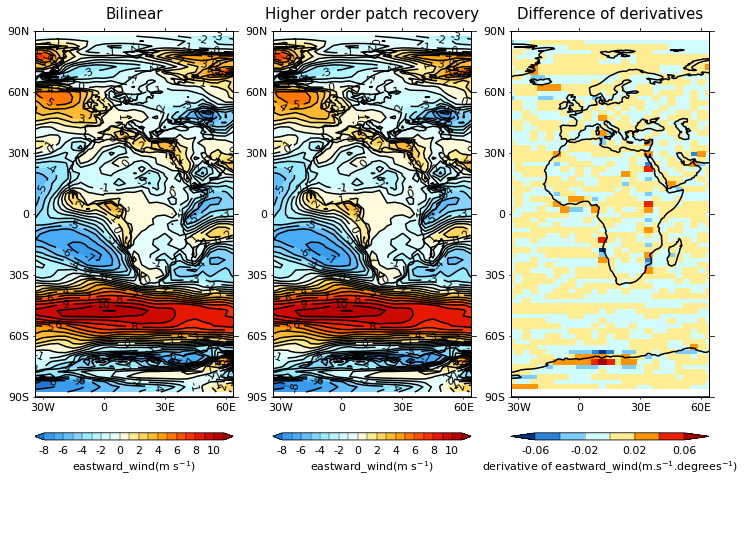

In [17]:
# Plot the regridded fields and the differences between the derivatives
cfp.gopen(rows=1, columns=3)
cfp.gpos(1)
cfp.con(h, colorbar_label_skip=2, title='Bilinear')
cfp.gpos(2)
cfp.con(i, colorbar_label_skip=2, title='Higher order patch recovery')
cfp.gpos(3)
cfp.levs(min=-0.06, max=0.06, step=0.02)
cfp.cscale('scale1')
cfp.con(deriv_i - deriv_h, blockfill=True, lines=False, colorbar_label_skip=2, title='Difference of derivatives')
cfp.gclose()

### Regridding an integer field using the nearest neighbour method

In [18]:
# Read in ncas_data/regions_low_res.nc and inspect the field
f = cf.read('ncas_data/regions.nc')[0]
print(f)

Field: region (ncvar%Regionmask)
--------------------------------
Data            : region(latitude(145), longitude(53))
Dimension coords: latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(53) = [-33.75, ..., 63.75] degrees_east



In [19]:
# Read in ncas_data/model_precip_DJF_means_low_res.nc and inspect the field
g = cf.read('ncas_data/model_precip_DJF_means_low_res.nc')[0]
print(g)

Field: long_name=precipitation (ncvar%precip)
---------------------------------------------
Data            : long_name=precipitation(long_name=t(1), long_name=Surface(1), latitude(73), longitude(27)) mm/day
Cell methods    : long_name=t(1): mean
Dimension coords: long_name=t(1) = [1996-07-16 00:00:00] 360_day
                : long_name=Surface(1) = [0.0] level
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east



In [20]:
# Regrid regions to model grid using nearest source to destination regridding and inspect the result
h = f.regrids(g, method='nearest_stod')
print(h)

Field: region (ncvar%Regionmask)
--------------------------------
Data            : region(latitude(73), longitude(27))
Dimension coords: latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east



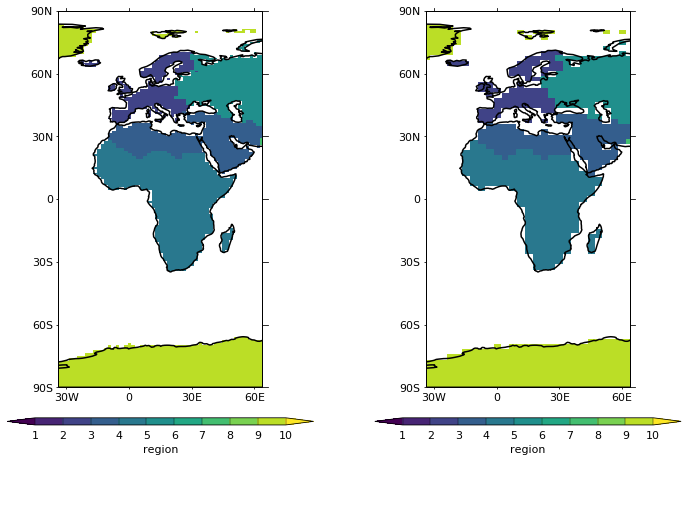

In [21]:
# Plot before and after
cfp.gopen(rows=1, columns=2)
cfp.levs(min=1, max=10, step=1)
cfp.cscale()
cfp.gpos(1)
cfp.con(f, blockfill=True, lines=False)
cfp.gpos(2)
cfp.con(h, blockfill=True, lines=False)
cfp.gclose()

### Regridding with constructed coordinates

In [22]:
# Read in ncas_data/precip_2010.nc and inspect the field
f = cf.read('ncas_data/precip_2010.nc')[0]
print(f)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(12), latitude(145), longitude(53)) mm
Dimension coords: long_name=time(12) = [2010-01-16 00:00:00, ..., 2010-12-16 00:00:00] gregorian
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(53) = [-33.75, ..., 63.75] degrees_east



In [23]:
# Create dimension coordinates for the destination grid
import numpy as np
lon = cf.DimensionCoordinate(data=cf.Data(np.arange(-33, 64, 2.0), 'degrees_east'))
lat = cf.DimensionCoordinate(data=cf.Data(np.arange(-90, 91, 2.0), 'degrees_north'))

In [24]:
# Create Voronoi bounds for the new dimension coordinates
lon_bounds = lon.create_bounds()
lat_bounds = lat.create_bounds(min=-90, max=90)
lon.set_bounds(lon_bounds)
lat.set_bounds(lat_bounds)

In [25]:
# Regrid the field to the grid of the new coordinates bilinearly and inspect the resulting field
g = f.regrids({'longitude': lon, 'latitude': lat}, method='conservative')
print(g)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(12), latitude(91), longitude(49)) mm
Dimension coords: long_name=time(12) = [2010-01-16 00:00:00, ..., 2010-12-16 00:00:00] gregorian
                : latitude(91) = [-90.0, ..., 90.0] degrees_north
                : longitude(49) = [-33.0, ..., 63.0] degrees_east



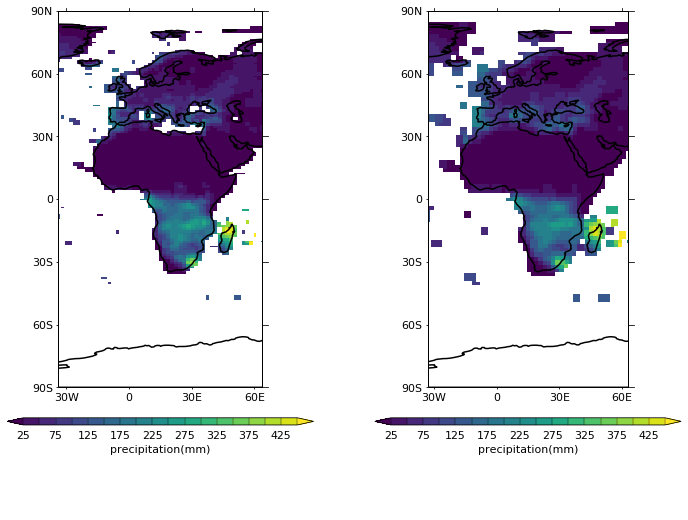

In [26]:
# Plot before and after
cfp.gopen(rows=1, columns=2)
cfp.levs()
cfp.gpos(1)
cfp.con(f[0], blockfill=True, lines=False, colorbar_label_skip=2)
cfp.gpos(2)
cfp.con(g[0], blockfill=True, lines=False, colorbar_label_skip=2)
cfp.gclose()

## Cartesian regridding (regridc)

### Regridding a time series

In [27]:
# Read in ncas_data/precip_1D_yearly.nc and inspect the field
f = cf.read('ncas_data/precip_1D_yearly.nc')[0]
print(f)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(10), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=time(10): mean long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(10) = [1981-07-02 00:00:00, ..., 1990-07-02 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east



In [28]:
# Read in ncas_data/precip_1D_monthly.nc and inspect the field
g = cf.read('ncas_data/precip_1D_monthly.nc')[0]
print(g)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(120), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(120) = [1981-01-16 00:00:00, ..., 1990-12-16 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east



In [29]:
# Regrid the first field to the grid of the second linearly and summarize the resulting field
h = f.regridc(g, axes='T', method='bilinear')
print(h)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(120), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=time(120): mean long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(120) = [1981-01-16 00:00:00, ..., 1990-12-16 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east



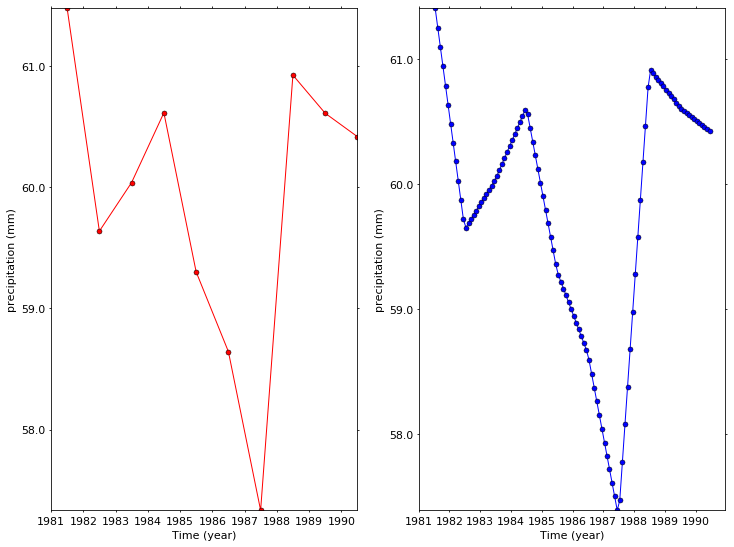

In [30]:
# Plot before and after
cfp.gopen(rows=1, columns=2)
cfp.gpos(1)
cfp.lineplot(f, marker='o', color='red')
cfp.gpos(2)
cfp.lineplot(h, marker='o', color='blue')
cfp.gclose()

### 2D cartesian regridding

In [31]:
# Read in ncas_data/u_216.nc and inspect the field
f = cf.read('ncas_data/u_n216.nc')[0]
print(f)

Field: eastward_wind (ncvar%u)
------------------------------
Data            : eastward_wind(long_name=t(1), long_name=Pressure(39), latitude(325), longitude(1)) m s-1
Dimension coords: long_name=t(1) = [1850-01-16 00:00:00] 360_day
                : long_name=Pressure(39) = [1000.0, ..., 0.029999999329447746] mbar
                : latitude(325) = [-90.0, ..., 90.00000762939453] degrees_north
                : longitude(1) = [358.33331298828125] degrees_east



In [32]:
# Read in ncas_data/u_96.nc and inspect the field
g = cf.read('ncas_data/u_n96.nc')[0]
print(g)

Field: eastward_wind (ncvar%u)
------------------------------
Data            : eastward_wind(long_name=t(1), air_pressure(19), latitude(145), longitude(1)) m s-1
Dimension coords: long_name=t(1) = [1850-01-16 00:00:00] 360_day
                : air_pressure(19) = [1000, ..., 1] mbar
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(1) = [356.25] degrees_east



In [33]:
# Save the pressure coordinates and their keys
p_src = f.coordinate('Z').copy()
p_dst = g.coordinate('Z').copy()

In [34]:
# Take the log of the pressures
f.coordinate('Z').log(base=10, inplace=True)
g.coordinate('Z').log(base=10, inplace=True)

In [35]:
# Regrid the source field and inspect the result
h = f.regridc(g, axes=('Y', 'Z'), method='bilinear')
print(h)

Field: eastward_wind (ncvar%u)
------------------------------
Data            : eastward_wind(long_name=t(1), ncdim%air_pressure(19), latitude(145), longitude(1)) m s-1
Dimension coords: long_name=t(1) = [1850-01-16 00:00:00] 360_day
                : ncvar%air_pressure(ncdim%air_pressure(19)) = [3.0, ..., 0.0] lg(re 100 Pa)
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(1) = [358.33331298828125] degrees_east



In [36]:
# Insert the saved destination pressure coordinate into the regridded field
h.replace_construct('Z', p_dst)
print(h)

Field: eastward_wind (ncvar%u)
------------------------------
Data            : eastward_wind(long_name=t(1), air_pressure(19), latitude(145), longitude(1)) m s-1
Dimension coords: long_name=t(1) = [1850-01-16 00:00:00] 360_day
                : air_pressure(19) = [1000, ..., 1] mbar
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(1) = [358.33331298828125] degrees_east



In [37]:
# Reinsert the saved pressure coordinates into the original fields
f.replace_construct('Z', p_src)
g.replace_construct('Z', p_dst)

<CF DimensionCoordinate: ncvar%air_pressure(19) lg(re 100 Pa)>

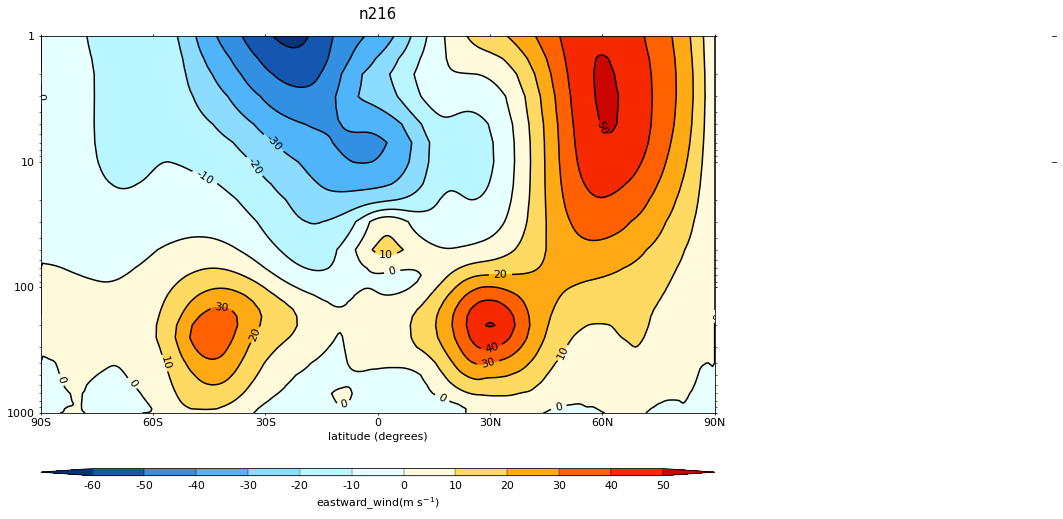

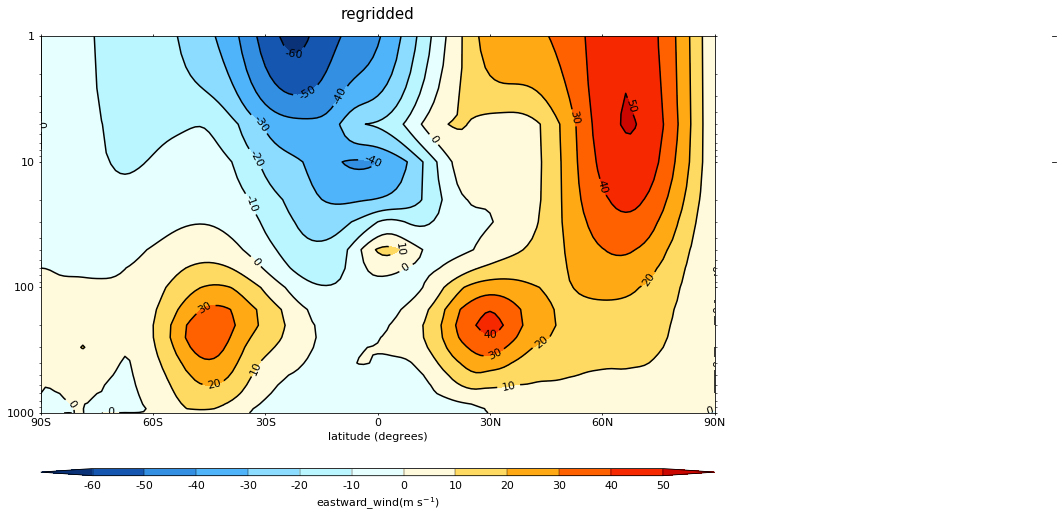

In [38]:
# Plot before and after
cfp.con(f, title='n216', ylog=True)
cfp.con(g, title='regridded', ylog=True)